# Employment Salary Prediction Model

## Problem Statement

As an employer, what should the salary be listed at given a criteria? Given my skills what should I expect to be paid? What is most important to contributing to a higher paying job? What kind of experience do I need to get paid more?

***Objective***:
- To determine a data scientist’s salary based on historical data. 
- Predict salaries for future years.
- Predict salaries for experience level

***Hypothesis*** <br>
A greater level of experience leads to a higher salary <br>
A later year leads to a higher salary

## Dataset

    The dataset contains 11 features and ~1100 entries. The feature we are trying to predict is salary in USD but converted to CAD. The data was collected online using an online survey. The information submitted is anonymous.
   source:https://salaries.ai-jobs.net/

***Attributes***

- Experience level (EN-EX)
    - EN Entry
    - MI Junior
    - SE Senior
    - EX Expert
- Work Year
    - Year worked in
- Job title
    - Title of position
- Salary in usd
    - Dollars in USD for the year

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sweetviz as sv
from sklearn import linear_model
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [2]:
df = pd.read_csv('salaries.csv')
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Architect,225000,USD,225000,US,100,US,M
1,2022,SE,FT,Data Architect,66000,USD,66000,US,100,US,M
2,2022,SE,FT,Data Scientist,185000,USD,185000,US,100,US,M
3,2022,SE,FT,Data Scientist,50000,USD,50000,US,100,US,M
4,2022,SE,FT,Data Scientist,45000,EUR,47546,ES,0,ES,M
...,...,...,...,...,...,...,...,...,...,...,...
1120,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
1121,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
1122,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
1123,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [3]:
df = df.drop(columns=['employment_type','salary_currency', 'employee_residence','company_location','remote_ratio','salary','company_size'])
df.head()

,work_year,experience_level,job_title,salary_in_usd
0,2022,SE,Data Architect,225000
1,2022,SE,Data Architect,66000
2,2022,SE,Data Scientist,185000
3,2022,SE,Data Scientist,50000
4,2022,SE,Data Scientist,47546


Only interested in the features we're observing

### Convert Salary USD to canadian

Interested in canadian dollars. For an easier comparison of respective salaries

In [4]:
import requests

url = 'https://v6.exchangerate-api.com/v6/645fb076fdb993a52a039414/latest/USD'

response = requests.get(url)
data = response.json()

conversion_rates = data['conversion_rates']
print(conversion_rates['CAD'])

#converts salary to cad with latest rates
df['salary_in_cad'] = df['salary_in_usd'].apply(lambda x: x*conversion_rates['CAD'])
df

1.3456


,work_year,experience_level,job_title,salary_in_usd,salary_in_cad
0,2022,SE,Data Architect,225000,302760.0000
1,2022,SE,Data Architect,66000,88809.6000
2,2022,SE,Data Scientist,185000,248936.0000
3,2022,SE,Data Scientist,50000,67280.0000
4,2022,SE,Data Scientist,47546,63977.8976
...,...,...,...,...,...
1120,2020,SE,Data Scientist,412000,554387.2000
1121,2021,MI,Principal Data Scientist,151000,203185.6000
1122,2020,EN,Data Scientist,105000,141288.0000
1123,2020,EN,Business Data Analyst,100000,134560.0000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   work_year         1125 non-null   int64  
 1   experience_level  1125 non-null   object 
 2   job_title         1125 non-null   object 
 3   salary_in_usd     1125 non-null   int64  
 4   salary_in_cad     1125 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 44.1+ KB


In [6]:
df.head()

,work_year,experience_level,job_title,salary_in_usd,salary_in_cad
0,2022,SE,Data Architect,225000,302760.0000
1,2022,SE,Data Architect,66000,88809.6000
2,2022,SE,Data Scientist,185000,248936.0000
3,2022,SE,Data Scientist,50000,67280.0000
4,2022,SE,Data Scientist,47546,63977.8976


## EDA
Visualisation

In [7]:
df.describe()

,work_year,salary_in_usd,salary_in_cad
count,1125.000000,1125.000000,1125.000000
mean,2021.666667,121477.750222,163460.460699
std,0.596550,67222.053491,90453.995177
min,2020.000000,2324.000000,3127.174400
25%,2021.000000,72500.000000,97556.000000
50%,2022.000000,116914.000000,157319.478400
75%,2022.000000,160000.000000,215296.000000
max,2022.000000,600000.000000,807360.000000


In [8]:
data_report = sv.analyze(df)

In [9]:
data_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


***Report Results*** <br>
Salary in USD has the strongest correlation to experience level which is 0.53 <br>

### Plot the distribution of our salaries

(array([ 35.,  38.,  32.,  54.,  58.,  74.,  80.,  55.,  83.,  79.,  64.,
        107.,  62.,  50.,  52.,  56.,  47.,  29.,  14.,  11.,  23.,   5.,
          3.,   0.,   4.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   2.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  3127.1744  ,  19211.830912,  35296.487424,  51381.143936,
         67465.800448,  83550.45696 ,  99635.113472, 115719.769984,
        131804.426496, 147889.083008, 163973.73952 , 180058.396032,
        196143.052544, 212227.709056, 228312.365568, 244397.02208 ,
        260481.678592, 276566.335104, 292650.991616, 308735.648128,
        324820.30464 , 340904.961152, 356989.617664, 373074.274176,
        389158.930688, 405243.5872  , 421328.243712, 437412.900224,
        453497.556736, 469582.213248, 485666.86976 , 501751.526272,
        517836.182784, 533920.839296, 550005.495808, 566090.15232 ,
        582174.808832, 598259.465344, 614344.1

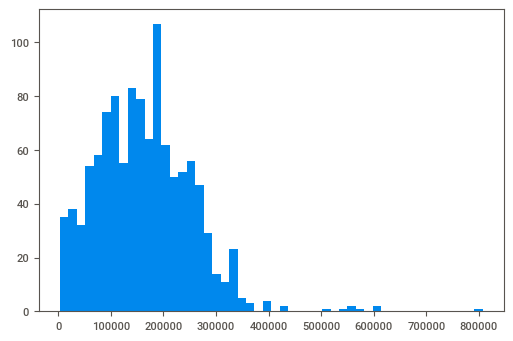

In [10]:
fix, axs = plt.subplots()
axs.hist(df['salary_in_cad'],label="Number",bins=50)

We see that most of our entries fall within ~0 - ~300, 000 salary. This is almost a binomial distrubution. Right-skewed 

### Observe the mean of salaries with expierence level

In [11]:
mean_salary_experience = df.groupby('experience_level')['salary_in_cad'].mean().sort_values()
mean_salary_experience = mean_salary_experience.reset_index()
mean_salary_experience

,experience_level,salary_in_cad
0,EN,78772.428179
1,MI,121305.379779
2,SE,194874.098757
3,EX,263236.971161


Let's look at the average salary per level of experience

<BarContainer object of 4 artists>

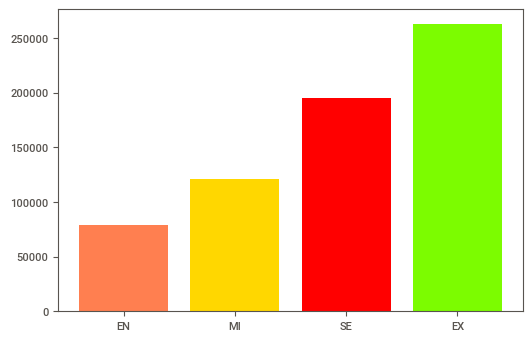

In [12]:
fig, ax = plt.subplots()
ax.bar(mean_salary_experience['experience_level'], mean_salary_experience["salary_in_cad"], color=['coral','gold','red','lawngreen'])

This figure shows the higher level of experience leads to a high salary

### Observe salaries respect to year

In [13]:
year = df['work_year']
salaries = df['salary_in_cad']

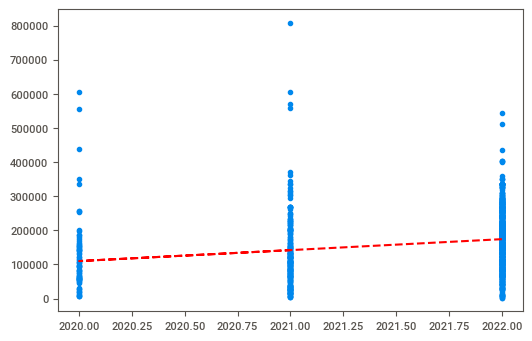

In [14]:
a, b = np.polyfit(year, salaries, 1)
plt.scatter(year, salaries)
plt.plot(year, a*year+b, color='red',linestyle='--')

We can see that salaries increase as the years continue. So we can assume our model will predict an increase in salaries at later years

In [15]:
mean_salary_year = df.groupby('work_year')['salary_in_cad'].mean().sort_values()
mean_salary_year = pd.DataFrame(mean_salary_year)
mean_salary_year = mean_salary_year.reset_index()
salary = mean_salary_year['salary_in_cad']

<BarContainer object of 3 artists>

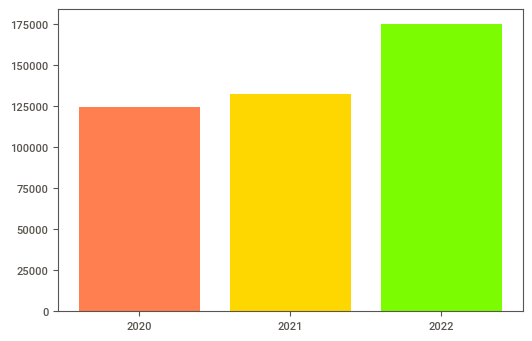

In [16]:
fig, ax = plt.subplots()
ax.bar(['2020','2021','2022'], salary, color=['coral','gold','lawngreen'])

The average salaries also increase over the years. So our model will predict an increase in salary over continuous years

### Observe job titles to salary

In [17]:
mean_salary_job = df.groupby('job_title')['salary_in_cad'].mean().sort_values(ascending=False)
mean_salary_job = mean_salary_job.reset_index()
mean_salary_job

,job_title,salary_in_cad
0,Data Analytics Lead,544968.000000
1,Principal Data Engineer,441805.333333
2,Cloud Data Architect,336400.000000
3,Principal Data Scientist,288419.364114
4,Financial Data Analyst,280333.333333
5,BI Analyst,269120.000000
6,Data Scientist Lead,246244.800000
7,Data Science Manager,242959.262400
8,Director of Data Science,238964.767600
9,Applied Scientist,231645.040000


<BarContainer object of 10 artists>

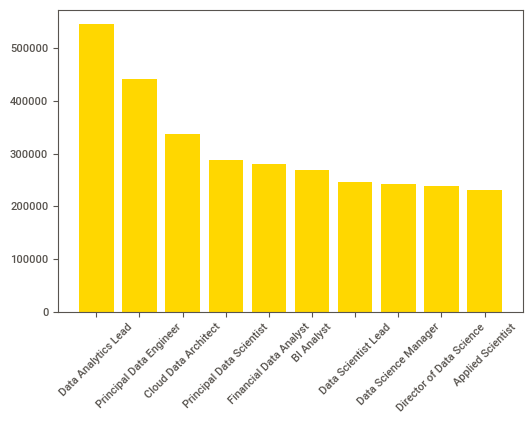

In [18]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
ax.bar(mean_salary_job['job_title'].head(10),mean_salary_job['salary_in_cad'].head(10), color=['gold'])

We can see which occuaptions in data science which have the greatest mean salary

In [19]:
mean_salary_job_count = df.groupby('job_title')['salary_in_cad'].count().sort_values(ascending=False)
mean_salary_job_count = mean_salary_job_count.reset_index()
mean_salary_job_count.head(10)

,job_title,salary_in_cad
0,Data Scientist,278
1,Data Engineer,259
2,Data Analyst,152
3,Machine Learning Engineer,77
4,Analytics Engineer,35
5,Data Architect,33
6,Data Science Manager,29
7,Research Scientist,20
8,Machine Learning Scientist,15
9,AI Scientist,12


<BarContainer object of 10 artists>

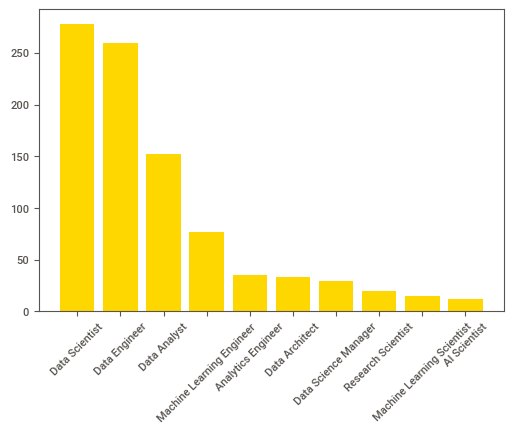

In [20]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
ax.bar(mean_salary_job_count['job_title'].head(10),mean_salary_job_count['salary_in_cad'].head(10), color=['gold'])

We see that more than half our data entries are in these 10 job titles

## Regression Model Classifier

***Model of salary to current year***

In [21]:
X = df[["work_year"]]

In [22]:
y = df[["salary_in_cad"]]

In [23]:
(X_train, X_vt, y_train, y_vt) = train_test_split(X, y, test_size=0.10, random_state=0) #90% training

In [24]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
prediction = regr.predict(X_vt)

In [25]:
rmse = np.sqrt(mean_squared_error(y_vt,prediction))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 102496.48195034555


In [26]:
regr.score(X_train,y_train)

0.05132966540560546

***Model of salary to Experience level***

In [27]:
X = df[["experience_level"]]
X

,experience_level
0,SE
1,SE
2,SE
3,SE
4,SE
...,...
1120,SE
1121,MI
1122,EN
1123,EN


Want to convert experience level to a categorigal number to work in our model

In [28]:
le = preprocessing.LabelEncoder()
le.fit(X)
encodedX = le.transform(X)
X_experience = pd.DataFrame(encodedX, columns=["experience_level"])
X_experience

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,experience_level
0,3
1,3
2,3
3,3
4,3
...,...
1120,3
1121,2
1122,0
1123,0


In [29]:
(X_train, X_vt, y_train, y_vt) = train_test_split(X_experience, y, test_size=0.20, random_state=0) #80% training

In [30]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
prediction = regr.predict(X_vt)

In [31]:
rmse = np.sqrt(mean_squared_error(y_vt,prediction))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 93880.68503543604


In [32]:
regr.score(X_train,y_train)

0.15945024684274056

In [33]:
regr.score(X_vt,y_vt)

0.10271249626634293

***Model of both attributes***

In [34]:
X = df[["work_year", "experience_level", "job_title"]]

In [35]:
X

,work_year,experience_level,job_title
0,2022,SE,Data Architect
1,2022,SE,Data Architect
2,2022,SE,Data Scientist
3,2022,SE,Data Scientist
4,2022,SE,Data Scientist
...,...,...,...
1120,2020,SE,Data Scientist
1121,2021,MI,Principal Data Scientist
1122,2020,EN,Data Scientist
1123,2020,EN,Business Data Analyst


In [36]:
le.fit(df[["job_title"]])
encoded_job_title = le.transform(df[["job_title"]])
X_job_title = pd.DataFrame(encoded_job_title, columns=["encoded_job_title"])

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Need to encode Experience level and job title

In [37]:
le.fit(df[["job_title"]])
encoded_job_title = le.transform(df[["job_title"]])
X_job_title = pd.DataFrame(encoded_job_title, columns=["encoded_job_title"])
X = pd.concat([df["work_year"],df["job_title"],X_job_title,X_experience],axis=1, join='inner')
#For observing job title to encoded data
X.head(10)

,work_year,job_title,encoded_job_title,experience_level
0,2022,Data Architect,20,3
1,2022,Data Architect,20,3
2,2022,Data Scientist,29,3
3,2022,Data Scientist,29,3
4,2022,Data Scientist,29,3
5,2022,Data Scientist,29,3
6,2022,Data Manager,23,2
7,2022,Data Manager,23,2
8,2022,Data Analyst,15,2
9,2022,Data Analyst,15,2


In [38]:
X= X.drop(columns='job_title')
X

,work_year,encoded_job_title,experience_level
0,2022,20,3
1,2022,20,3
2,2022,29,3
3,2022,29,3
4,2022,29,3
...,...,...,...
1120,2020,29,3
1121,2021,56,2
1122,2020,29,0
1123,2020,10,0


In [39]:
(X_train, X_vt, y_train, y_vt) = train_test_split(X, y, test_size=0.20, random_state=0) #80% training

In [40]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
prediction = regr.predict(X_vt)

In [41]:
rmse = np.sqrt(mean_squared_error(y_vt,prediction))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 92899.31445834164


# Ensemble Model

Our model isn't performing well to obtain an accurate salary prediction. Let's try an ensemble model with extreme gradient boosting

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor

#Our stacking algorithms
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingClassifier

In [43]:
xgboost = XGBRegressor()
xg_reg = GridSearchCV(xgboost, {})
xg_reg.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                    

In [44]:
#We see just using xgboost gives us a better performance ~ $20, 000 better
new_pred = xg_reg.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,new_pred))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 56610.8862612535


***Now let's include multiple models with a stacked regressor***

In [51]:
regressor_list=[]
regressor_list.append(LinearRegression())
regressor_list.append(LinearSVR())
regressor_list.append(DecisionTreeRegressor())
regressor_list.append(AdaBoostRegressor())
regressor_list.append(RandomForestRegressor())


Algo_list=["ols","svr","dtr","ar","rfr"]

estimators=[]
for i in range(0,len(regressor_list)):
    estimators.append([Algo_list[i],regressor_list[i]])
    
stack_reg = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=0),cv=5)
stack_reg.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblin

StackingRegressor(cv=5,
                  estimators=[['ols', LinearRegression()], ['svr', LinearSVR()],
                              ['dtr', DecisionTreeRegressor()],
                              ['ar', AdaBoostRegressor()],
                              ['rfr', RandomForestRegressor()]],
                  final_estimator=RandomForestRegressor(random_state=0))

In [52]:
stacking_pred = stack_reg.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,stacking_pred))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 77635.9998458294


Here we can see our model predicting a job salary for the encoded data analyst, '15' Highlighting that the year has changed with the same params. We can see that the salary is predicted to be greater.

In [53]:
stack_reg.predict([[2021,15,3]])

array([132298.88124549])

In [54]:
stack_reg.predict([[2022,15,3]])

array([155658.16154039])

Here we see the same job with lower experience level, resulting in a lower salary.

In [55]:
stack_reg.predict([[2022,15,2]])

array([113304.48859693])

***We can see that our model is working as expected.***